Universidade Federal do Pará\
Instituto de Ciências Exatas e Naturais\
Faculdade de Computação\
Equipe: Ana Paula (202111140019), Antônio Vidal (202111140003), Lucas Moreno (201904940025), Luis Carlos (201904940012) e Rodrigo Gois (202011140002)


# Importação das Bibliotecas


In [22]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from joblib import dump
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Carregamento dos Dados


In [23]:
try:
    df = pd.read_csv("data/sods.csv")
    # Exibição do DataFrame
    display(df.head())
except FileNotFoundError as error:
    print(error)
except Exception as error:
    print(error)

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...


# Análise Inicial dos Dados


<Axes: title={'center': 'Valores Ausentes por Coluna'}>

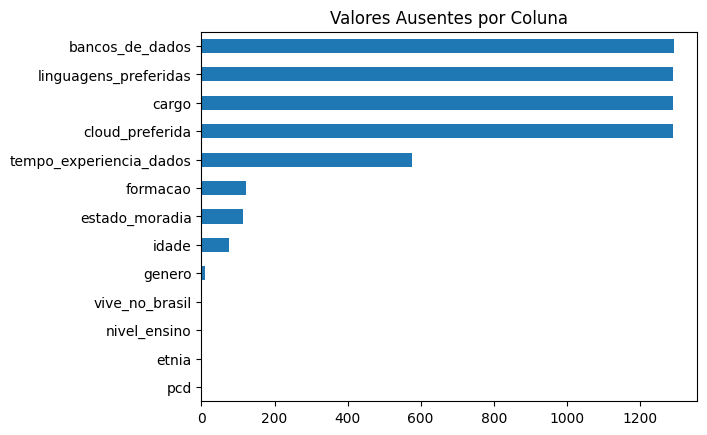

In [24]:
# Visualização dos Valores Ausentes por Coluna
df.isnull().sum().sort_values(ascending=True).plot(
    kind="barh", title="Valores Ausentes por Coluna"
)

<Axes: title={'center': 'Distribuição de cargo'}, ylabel='cargo'>

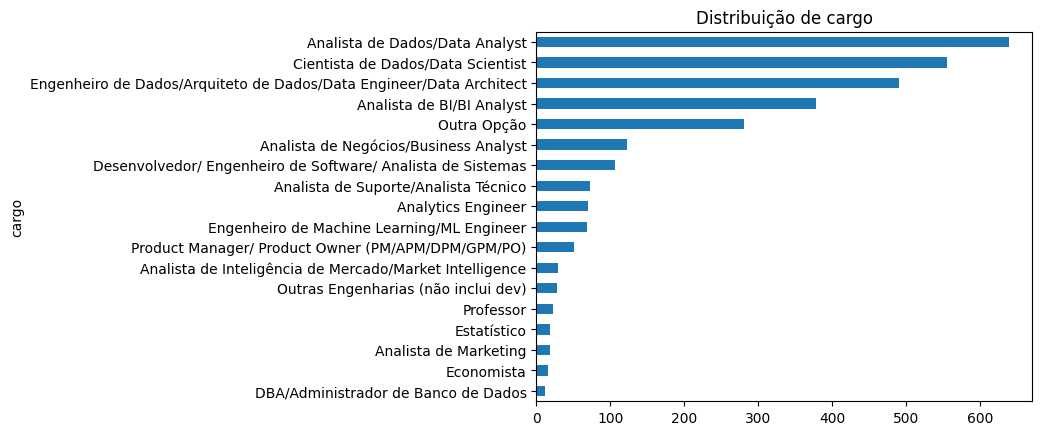

In [ ]:
# Visualização da Distribuição dos Cargos
df["cargo"].value_counts().sort_values(ascending=True).plot(
    kind="barh", title="Distribuição de Cargos"
)

# Pré-Processamento


In [26]:
# Copiando DataFrame para Pré-Processamento
pp_df = df.copy()

# Mostrando Informações do DataFrame
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    4197 non-null   float64
 1   genero                   4262 non-null   object 
 2   etnia                    4271 non-null   object 
 3   pcd                      4271 non-null   object 
 4   vive_no_brasil           4271 non-null   bool   
 5   estado_moradia           4156 non-null   object 
 6   nivel_ensino             4271 non-null   object 
 7   formacao                 4149 non-null   object 
 8   tempo_experiencia_dados  3694 non-null   object 
 9   linguagens_preferidas    2979 non-null   object 
 10  bancos_de_dados          2978 non-null   object 
 11  cloud_preferida          2981 non-null   object 
 12  cargo                    2981 non-null   object 
dtypes: bool(1), float64(1), object(11)
memory usage: 404.7+ KB


In [27]:
# Removendo Linhas com Valores Ausentes na Coluna "cargo"
pp_df = pp_df.dropna(subset=["cargo"])

# Preenchendo os Valores Ausentes na Coluna "idade" com a Mediana e Convertendo para Inteiro
pp_df["idade"] = pp_df["idade"].fillna(pp_df["idade"].median()).astype(int)

# Preenchendo os Valores Ausentes na Coluna "genero" com a Moda
pp_df["genero"] = pp_df["genero"].fillna(pp_df["genero"].mode()[0])

# Preenchendo os Valores Ausentes na Coluna "formacao" com "nenhuma"
pp_df["formacao"] = pp_df["formacao"].fillna("nenhuma")

# Removendo Quaisquer Linhas com Valores Ausentes
pp_df = pp_df.dropna()

In [28]:
# Descartando Colunas Que Não Serão Utilizadas
pp_df = pp_df.drop(columns=["pcd", "vive_no_brasil", "bancos_de_dados"])

# Mostrando Informações do DataFrame
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2906 entries, 0 to 4270
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   idade                    2906 non-null   int64 
 1   genero                   2906 non-null   object
 2   etnia                    2906 non-null   object
 3   estado_moradia           2906 non-null   object
 4   nivel_ensino             2906 non-null   object
 5   formacao                 2906 non-null   object
 6   tempo_experiencia_dados  2906 non-null   object
 7   linguagens_preferidas    2906 non-null   object
 8   cloud_preferida          2906 non-null   object
 9   cargo                    2906 non-null   object
dtypes: int64(1), object(9)
memory usage: 249.7+ KB


# Transformação


In [29]:
# Copiando DataFrame para Pré-Processamento
tt_df = pp_df.reset_index(drop=True).copy()

# Mostrando Informações do DataFrame
tt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   idade                    2906 non-null   int64 
 1   genero                   2906 non-null   object
 2   etnia                    2906 non-null   object
 3   estado_moradia           2906 non-null   object
 4   nivel_ensino             2906 non-null   object
 5   formacao                 2906 non-null   object
 6   tempo_experiencia_dados  2906 non-null   object
 7   linguagens_preferidas    2906 non-null   object
 8   cloud_preferida          2906 non-null   object
 9   cargo                    2906 non-null   object
dtypes: int64(1), object(9)
memory usage: 227.2+ KB


## Normalização de Colunas Textuais


In [30]:
def normalize_column(column):
    return (
        column.str.lower()
        .str.strip()
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
    )


tt_df.iloc[:, 1:] = tt_df.iloc[:, 1:].apply(normalize_column)
tt_df.head()

,idade,genero,etnia,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,cloud_preferida,cargo
0,39,masculino,parda,distrito federal (df),pos-graduacao,computacao / engenharia de software / sistemas...,de 1 a 2 anos,r,amazon web services (aws),dba/administrador de banco de dados
1,53,masculino,branca,distrito federal (df),pos-graduacao,computacao / engenharia de software / sistemas...,de 3 a 4 anos,python,amazon web services (aws),desenvolvedor/ engenheiro de software/ analist...
2,27,masculino,branca,minas gerais (mg),doutorado ou phd,estatistica/ matematica / matematica computaci...,de 4 a 6 anos,python,nao sei opinar,cientista de dados/data scientist
3,46,feminino,branca,para (pa),pos-graduacao,computacao / engenharia de software / sistemas...,nao tenho experiencia na area de dados,python,amazon web services (aws),desenvolvedor/ engenheiro de software/ analist...
4,32,feminino,parda,ceara (ce),pos-graduacao,ciencias biologicas/ farmacia/ medicina/ area ...,nao tenho experiencia na area de dados,python,google cloud (gcp),professor


## Mapeamento dos Níveis de Ensino


In [31]:
nivel_ensino_map = {
    "estudante de graduacao": 1,
    "graduacao/bacharelado": 2,
    "pos-graduacao": 3,
    "mestrado": 4,
    "doutorado ou phd": 5,
    "nao tenho graduacao formal": 0,
    "prefiro nao informar": 0,
}
tt_df["nivel_ensino"] = tt_df["nivel_ensino"].map(nivel_ensino_map)

## Mapeamento dos Tempos de Experiência


In [32]:
tempo_experiencia_dados_map = {
    "menos de 1 ano": 0.5,
    "de 1 a 2 anos": 1.5,
    "de 3 a 4 anos": 3.5,
    "de 4 a 6 anos": 5.0,
    "de 7 a 10 anos": 8.0,
    "mais de 10 anos": 12.0,
    "nao tenho experiencia na area de dados": 0.0,
}
tt_df["tempo_experiencia_dados"] = tt_df["tempo_experiencia_dados"].map(
    tempo_experiencia_dados_map
)

## Tratamento das Linguagens Preferidas


In [33]:
linguagens_preferidas_map = {
    "pyspark": "spark",
    "xlsx": "excel",
    "m language": "m",
    "aql": "sql",
    "sql postegres": "sql",
    "nao sei": "nenhuma",
    "nao utilizo": "nenhuma",
    "softwares estatisticos como spss": "nenhuma",
    "nao atuo com programacao": "nenhuma",
    "nenhum": "nenhuma",
    "nao uso": "nenhuma",
}
tt_df["linguagens_preferidas"] = tt_df["linguagens_preferidas"].replace(
    linguagens_preferidas_map
)

# Listando as 5 Linguagens Mais Comuns
pl_count = tt_df["linguagens_preferidas"].explode().value_counts()
common_pl = pl_count[pl_count >= 5].index

# Função de Agrupamento
tt_df["linguagens_preferidas"] = tt_df["linguagens_preferidas"].apply(
    lambda x: x if x in common_pl else "outro"
)

## Tratamento dos Cargos


In [34]:
cargos_map = {
    # Agrupando Cargos Similares a Análise de Dados
    "analista de bi/bi analyst": "analista de dados",
    "analista de dados/data analyst": "analista de dados",
    "analista de negocios/business analyst": "analista de dados",
    "analista de inteligencia de mercado/market intelligence": "analista de dados",
    # Agrupando Cargos Similares a Ciência de Dados
    "cientista de dados/data scientist": "cientista de dados",
    "estatistico": "cientista de dados",
    # Agrupando Cargos Similares a Engenharia de Dados
    "engenheiro de dados/arquiteto de dados/data engineer/data architect": "engenheiro de dados",
    "engenheiro de machine learning/ml engineer": "engenheiro de dados",
    "analytics engineer": "engenheiro de dados",
    "dba/administrador de banco de dados": "engenheiro de dados",
    # Agrupando Cargos Relacionados a TI / Engenharia
    "desenvolvedor/ engenheiro de software/ analista de sistemas": "outro (TI / engenharia)",
    "analista de suporte/analista tecnico": "outro (TI / engenharia)",
    "product manager/ product owner (pm/apm/dpm/gpm/po)": "outro (TI / engenharia)",
    "outras engenharias (nao inclui dev)": "outro (TI / engenharia)",
    # Agrupando Cargos com Poucas Ocorrências
    "outra opcao": "nenhum",
    "professor": "nenhum",
    "analista de marketing": "nenhum",
    "economista": "nenhum",
}
tt_df["cargo"] = tt_df["cargo"].map(cargos_map)
tt_df["cargo"].value_counts()

cargo
analista de dados          1141
engenheiro de dados         618
cientista de dados          563
nenhum                      330
outro (TI / engenharia)     254
Name: count, dtype: int64

# Treinamento


## Preparação dos Dados e do Preprocessador


In [35]:
# Separando os Dados em Variáveis Independentes (X) e Alvo (y)
X = tt_df.drop(columns=["cargo"])
y = tt_df["cargo"]

# Identificando Colunas Categóricas
categorical_columns = X.select_dtypes(include=["object", "bool"]).columns

# Definindo o Pré-Processador
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_columns,
        )
    ],
    remainder="passthrough",
)

# Aplicando o LabelEncoder para a Variável Alvo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividindo os Dados em Conjuntos de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Mostrando as Formas dos Conjuntos de Dados
print(f"X_train shape:{X_train.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape:{y_test.shape}")

X_train shape:(2034, 9)
y_train shape:(2034,)
X_test shape:(872, 9)
y_test shape:(872,)


## Random Forest


RandomForestClassifier → Best Params: {'classifier__n_estimators': 1000, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 'log2', 'classifier__max_depth': 10}


,accuracy,precision,recall,f1
train,0.570305,0.580970,0.570305,0.562142
test,0.509174,0.509035,0.509174,0.495917


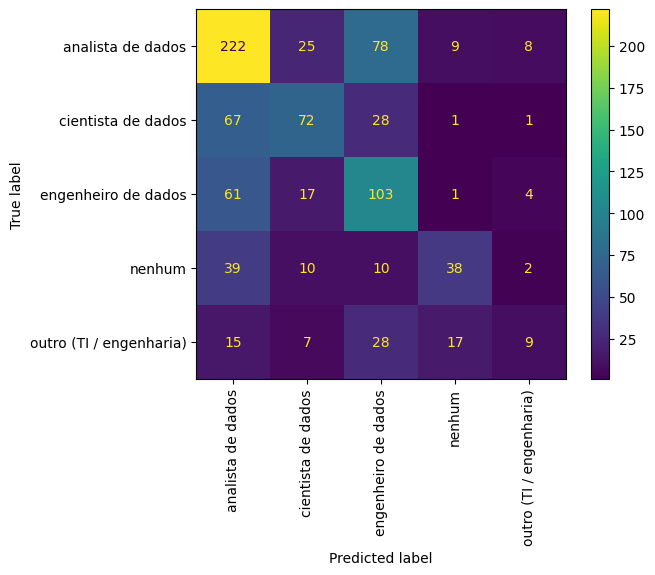

In [41]:
# Parâmetros do Random Forest
rf_params = {
    "classifier__n_estimators": [500, 700, 1000],
    "classifier__max_depth": [5, 10, 15],
    "classifier__min_samples_leaf": [2, 5, 10],
    "classifier__max_features": ["sqrt", "log2"],
}
random_forest = RandomForestClassifier(random_state=42)

# Criando o Pipeline com o Pré-Processador e SMOTETomek
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "smote",
            SMOTE(random_state=42, sampling_strategy="not majority", k_neighbors=10),
        ),
        ("classifier", random_forest),
    ]
)

# Executando o Randomized Search CV
search = RandomizedSearchCV(
    rf_pipeline, rf_params, scoring="f1_weighted", n_jobs=-1, cv=5, random_state=42
)
search.fit(X_train, y_train)

# Métricas de Treino
y_train_pred = search.predict(X_train)
train_metrics = {
    "accuracy": accuracy_score(y_train, y_train_pred),
    "precision": precision_score(
        y_train, y_train_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_train, y_train_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_train, y_train_pred, average="weighted", zero_division=0),
}

# Métricas de Teste
y_test_pred = search.predict(X_test)
test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(
        y_test, y_test_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_test, y_test_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_test, y_test_pred, average="weighted", zero_division=0),
}

# Visualização da Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(
    xticks_rotation="vertical"
)

# Visualização das Métricas de Avaliação
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["train", "test"])
print(f"{random_forest.__class__.__name__} → Best Params: {search.best_params_}")
display(metrics_df)


## Rede Neural (MLP)


MLPClassifier → Best Params: {'classifier__validation_fraction': 0.1, 'classifier__tol': 1e-05, 'classifier__solver': 'adam', 'classifier__n_iter_no_change': 20, 'classifier__max_iter': 1200, 'classifier__learning_rate_init': 0.001, 'classifier__hidden_layer_sizes': (128, 64), 'classifier__early_stopping': True, 'classifier__batch_size': 128, 'classifier__alpha': 0.01, 'classifier__activation': 'relu'}


,accuracy,precision,recall,f1
train,0.537365,0.570897,0.537365,0.537767
test,0.404817,0.453009,0.404817,0.408564


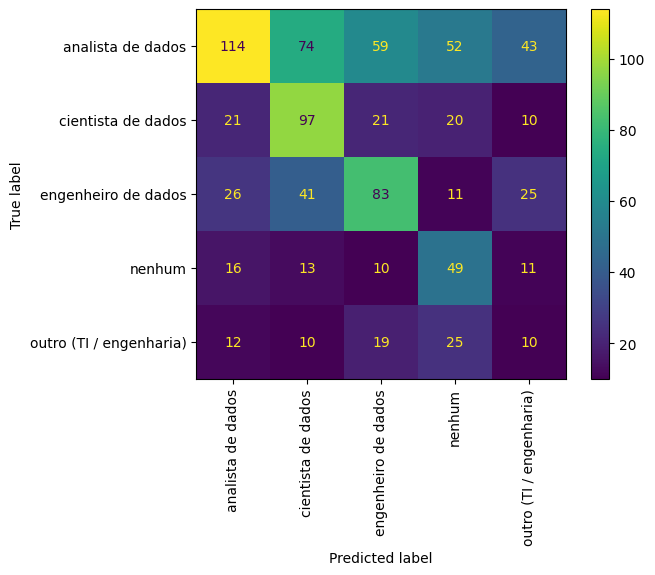

In [37]:
# Parâmetros da Rede Neural (MLP)
nn_params = {
    "classifier__hidden_layer_sizes": [(64, 64), (128, 64), (128, 128)],
    "classifier__activation": ["relu"],
    "classifier__solver": ["adam"],
    "classifier__alpha": [0.001, 0.003, 0.01],
    "classifier__batch_size": [64, 128],
    "classifier__learning_rate_init": [0.001, 0.002],
    "classifier__max_iter": [1200, 1500],
    "classifier__tol": [1e-5],
    "classifier__early_stopping": [True],
    "classifier__validation_fraction": [0.1, 0.2],
    "classifier__n_iter_no_change": [20, 30],
}
neural_network = MLPClassifier(random_state=42)

# Criando o Pipeline com o Pré-Processador e SMOTETomek
nn_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "smote",
            SMOTE(random_state=42, sampling_strategy="not majority", k_neighbors=10),
        ),
        ("classifier", neural_network),
    ]
)

# Executando o Randomized Search CV
search = RandomizedSearchCV(
    nn_pipeline, nn_params, scoring="f1_weighted", n_jobs=-1, cv=5, random_state=42
)
search.fit(X_train, y_train)

# Métricas de Treino
y_train_pred = search.predict(X_train)
train_metrics = {
    "accuracy": accuracy_score(y_train, y_train_pred),
    "precision": precision_score(
        y_train, y_train_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_train, y_train_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_train, y_train_pred, average="weighted", zero_division=0),
}

# Métricas de Teste
y_test_pred = search.predict(X_test)
test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(
        y_test, y_test_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_test, y_test_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_test, y_test_pred, average="weighted", zero_division=0),
}

# Visualização da Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(
    xticks_rotation="vertical",
)

# Visualização das Métricas de Avaliação
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["train", "test"])
print(f"{neural_network.__class__.__name__} → Best Params: {search.best_params_}")
display(metrics_df)

## Salvando Modelos e Encoder


In [42]:
try:
    # Salvando o Modelo Random Forest
    dump(rf_pipeline, "models/random_forest_model.joblib")

    # Salvando o Modelo Neural Network
    dump(nn_pipeline, "models/neural_network_model.joblib")

    # Salvando Encoder
    dump(label_encoder, "models/label_encoder.joblib")
    print("Modelos e Encoder Salvos na Pasta 'models/'")
except Exception as error:
    print(error)

Modelos e Encoder Salvos na Pasta 'models/'
